In [26]:
import soundfile as sf
import numpy as np
import scipy as signal
import matplotlib.pyplot as plt
from functools import lru_cache

In [27]:
# Load data
data1,samplerate = sf.read('/Users/hyh/Desktop/Test Files/Postfiltered/postfiltered_2020-01-08_09_25_03_1.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )
data2,samplerate = sf.read('/Users/hyh/Desktop/Test Files/Postfiltered/postfiltered_2020-01-08_09_25_03_2.raw', 
               channels=4, 
               samplerate=16000,
               subtype='PCM_16'
              )

## Functions

In [29]:
def truncate(sig1, sig2):
    '''
    This function truncates the longer signal and return two signals of the same length
    '''
    l1, l2 = len(sig1), len(sig2)
    if l1 <= l2:
        return sig1, sig2[0:l1]
    else:
        return sig1[0:l2], sig2

def prepadding(sig1, sig2, winDuration, Fs):
    l = winDuration * Fs
    N = len(sig1)    
    # Padding to have an interger number of windows
    if N%l != 0:
        padWidth = l-N%l
        sig1 = np.pad(sig1, (0, padWidth), 'constant', constant_values = 0)
        sig2 = np.pad(sig2, (0, padWidth), 'constant', constant_values = 0)
        
    numOfWindows = len(sig1)/l
    
    return sig1, sig2, numOfWindows

def whiten(sig):
    return sig/np.abs(sig)

def gcc_phat(sig1, sig2, fs=16000, max_tau=None, interp=1, window=True, windowName="hamming"):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method. In this modified
    function, sig1 and sig2 are garuanteed to have the same length
    '''
    # Make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n1, n2 = sig1.shape[0], sig2.shape[0]
    n = n1 + n2
    
    # Add window
    if window: 
        win1 = getattr(np, windowName)(n1)
        win2 = getattr(np, windowName)(n2)
        sig1 = sig1 * win1
        sig2 = sig2 * win2

    # Generalized Cross Correlation Phase Transform
    SIG1 = np.fft.rfft(sig1, n=n)
    SIG2 = np.fft.rfft(sig2, n=n)
    
    W1 = whiten(SIG1)
    W2 = whiten(SIG2)
    
    R = W1 * np.conj(W2)
    
    cc = np.fft.irfft(R, n=(interp * n))

    # cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = np.float(shift / float(interp * fs))
    
    return tau, cc, R, SIG1, SIG2

## Extract delay across ODAS2 & ODAS3

In [46]:
'''
Between two devices, each device generates 4 channels/arrays
The number of possible gcc-phat combinations is 2*(4!)/(1!(4-1)!) = 16
'''
'''
         Fs: Sampling Frequency
WinDuration: The length of the moving window in time (s)
  tauPerWin: An array that keeps track of delay per window
'''

# This needs to be turned into a for loop for all 4 channels
# Need to make sure the number of windows are the same across all comparisons

winDuration, Fs = 1, 16000
sig1, sig2 = truncate(data2[:,0], data2[:,1])
sig1, sig2, numOfWindows = prepadding(sig1, sig2, winDuration, Fs)


# for i in range(0,numOfWindows):
#     sig1Temp, sig2Temp = sig1[i*l:l*(i+1)], sig2[i*l:l*(i+1)]

max_tau = 5/340
l = winDuration * Fs

for i in range(97,98):
    sig1Temp, sig2Temp = sig1[i*l:l*(i+1)], sig2[i*l:l*(i+1)]
    tau, cc, R, SIG1, SIG2 = gcc_phat(sig1Temp, sig2Temp, fs=16000)

In [47]:
tau

-6.25e-05

96-97 tau = -6.25e-05


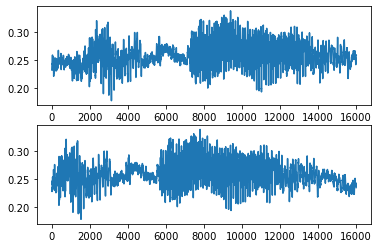

In [48]:
temp = sig1[int(97.1*16000):int(98.1*16000)]
plt.subplot(2,1,1)
plt.plot(sig1Temp)
plt.subplot(2,1,2)
plt.plot(temp)

In [51]:
tau, cc, R, SIG1, SIG2 = gcc_phat(sig1Temp, temp, fs=16000, window=False)

In [52]:
tau

0.1

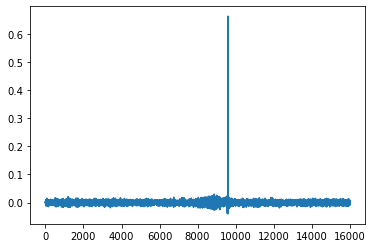

In [53]:
plt.plot(cc)

In [6]:
# @lru_cache
# def fact(n):
#     if n <= 1:
#         return 1
#     return n * fact(n-1)

# fact(8)/fact(2)/fact(6)

28.0